# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-10"

## Introduction

Normalize data and create embeddings for each time point fraction

In [2]:
timepoint <- "T4"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_119_120/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

## Remove potential erythrocytes

In [6]:
seurat_obj <- subset(x = seurat_obj, 
                     subset = HBM == 0 & HEMGN == 0 & HBG2 == 0)

In [7]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.0 GiB”



FALSE  TRUE 
26314  1747 


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.0 GiB”


An object of class Seurat 
26314 features across 9799 samples within 1 assay 
Active assay: RNA (26314 features, 0 variable features)
 4 dimensional reductions calculated: pca, umap, pca_filt, harmony

In [8]:
seurat_obj <- DietSeurat(
  seurat_obj,
  counts = TRUE,
  data = TRUE,
  scale.data = FALSE,
  features = NULL,
  assays = NULL,
  dimreducs = FALSE,
  graphs = NULL
)

### Re-do embedding

In [9]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [10]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 26314 9799 
metadata(0):
assays(2): counts logcounts
rownames(26314): AL627309.1 AL627309.3 ... AC141272.1 AC007325.2
rowData names(0):
colnames(9799): T4_1_AAACCTGAGTACGCGA-1 T4_1_AAACCTGAGTGCTGCC-1 ...
  T4_2_TTTGTCATCCAGATCA-1 T4_2_TTTGTCATCTAAGCCA-1
colData names(16): orig.ident nCount_RNA ... old.ident ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

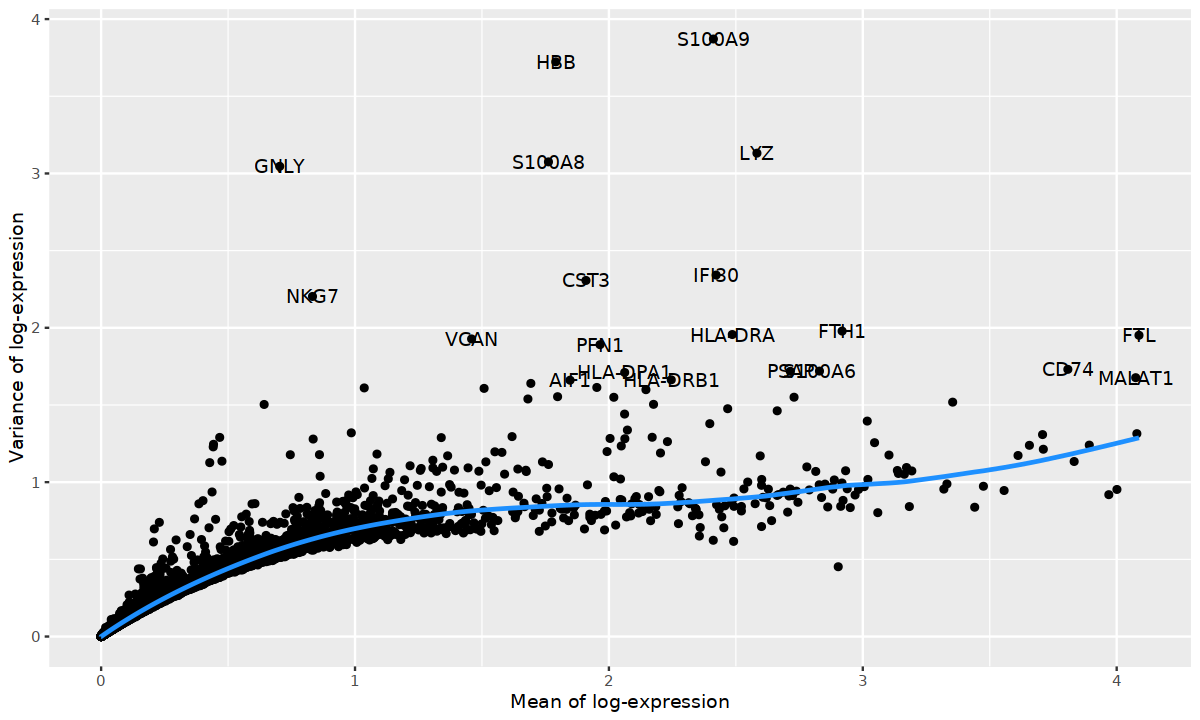

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [12]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 1086

In [13]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

In [14]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  IFI30, LYZ, AIF1, FCN1, FTL, CTSS, LST1, PSAP, HLA-DRA, CYBB 
	   S100A9, SPI1, NAMPT, SERPINA1, GRN, CD68, PLXDC2, LYN, HLA-DRB1, CST3 
	   S100A6, S100A11, HLA-DQB1, MNDA, SAT1, MS4A6A, SLC8A1, VCAN, S100A8, FTH1 
Negative:  CD247, PRF1, CTSW, GZMA, SKAP1, CD7, CST7, GNLY, PRKCH, NKG7 
	   ZAP70, IL32, IL2RB, GZMB, SYNE2, KLRK1, CD96, SAMD3, IL2RG, GZMM 
	   KLRD1, KLRB1, SLC38A1, CD69, LCK, CCL5, GZMH, HOPX, PYHIN1, KLRC1 
PC_ 2 
Positive:  S100A4, TYROBP, FCER1G, CD74, LGALS1, IFITM3, FOS, IFITM2, S100A11, CRIP1 
	   S100A6, NEAT1, CD52, JUNB, S100A10, PSAP, IFITM1, CTSS, NKG7, FCGR3A 
	   ANXA1, PRF1, GZMA, ZEB2, IFI30, GNLY, VIM, PFN1, HLA-DRB1, GNG2 
Negative:  ALAS2, HBA1, HBA2, CA1, HBB, HBD, SNCA, AHSP, SELENBP1, SLC4A1 
	   DMTN, DCAF12, BCL2L1, BPGM, KRT1, SLC25A37, ANK1, TRIM58, EPB42, OSBP2 
	   IFIT1B, SLC25A39, MYL4, UBB, TENT5C, BEX3, GYPB, PTCRA, GNG11, EGFL7 
PC_ 3 
Positive:  GP9, TUBB1, ITGA2B, PF4, PPBP, MPIG6B,

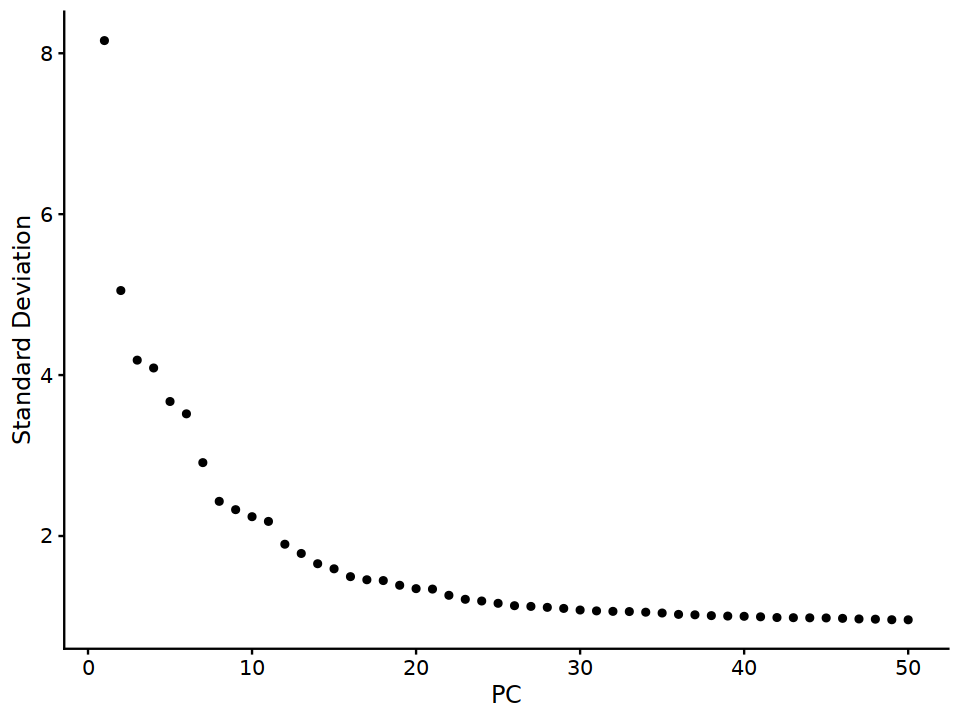

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

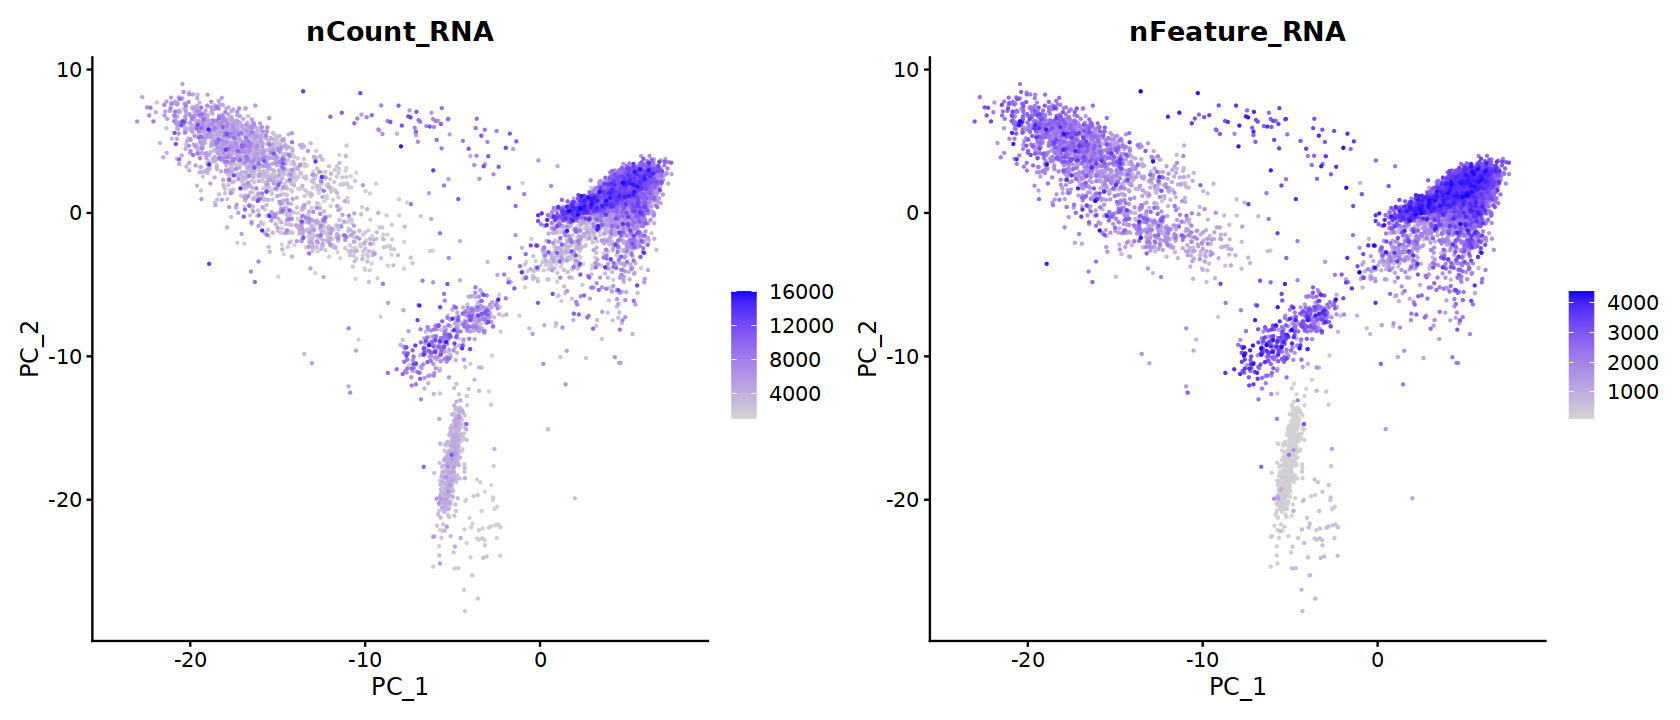

In [16]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

In [17]:
comp=15

Integrate with harmony

In [18]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

In [19]:
seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



In [20]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

10:49:34 UMAP embedding parameters a = 0.9922 b = 1.112

10:49:34 Read 9799 rows and found 15 numeric columns

10:49:34 Using Annoy for neighbor search, n_neighbors = 30

10:49:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:49:35 Writing NN index file to temp file /scratch_tmp/33943067/Rtmp2fDrGF/file191ec517786b1

10:49:35 Searching Annoy index using 1 thread, search_k = 3000

10:49:38 Annoy recall = 100%

10:49:39 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:49:40 Initializing from normalized Laplacian + noise (using irlba)

10:49:41 Commencing optimization for 500 epochs, with 409606 positive edges

10:50:07 Optimization finished



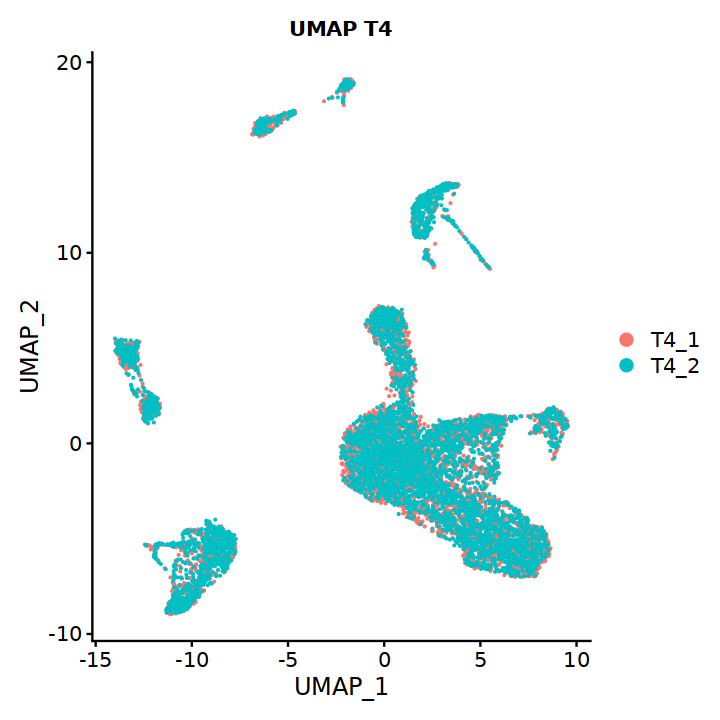

In [21]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Remove doublets

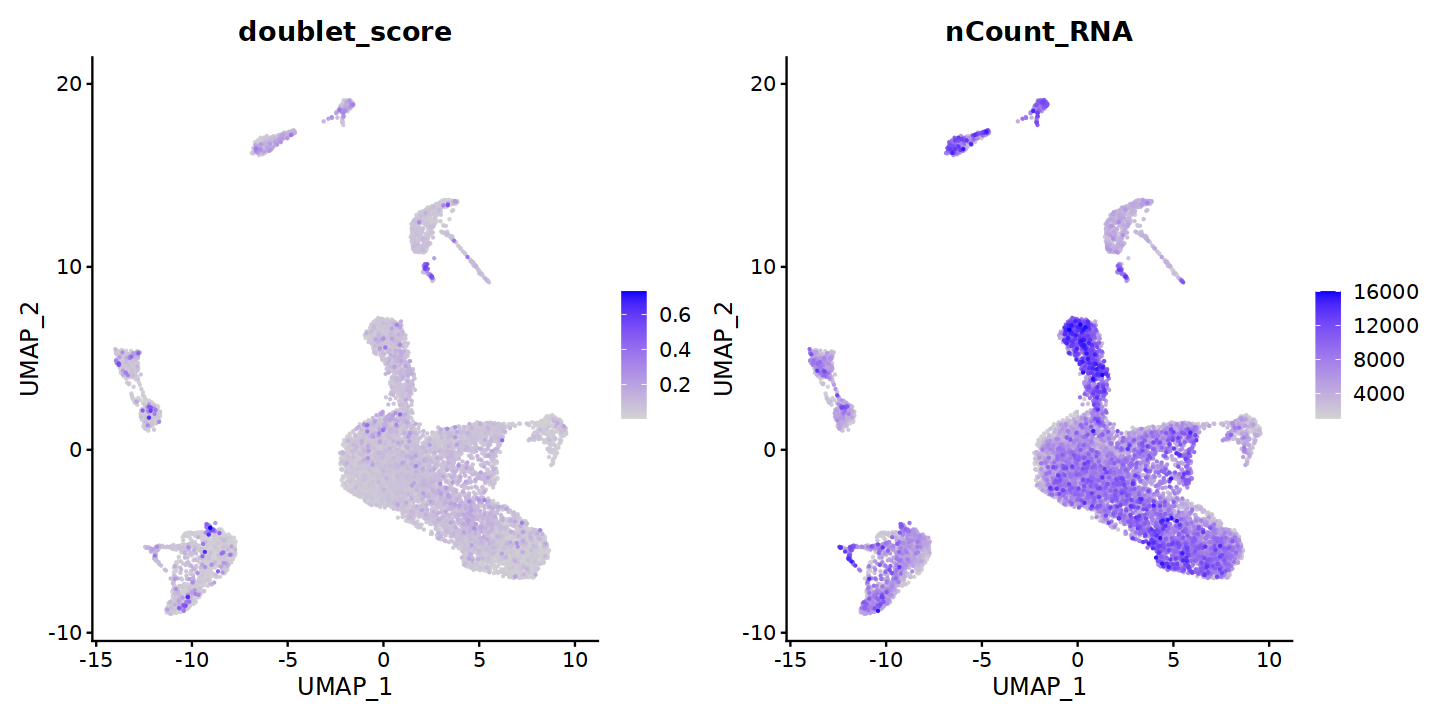

In [22]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, reduction = "umap", 
            feature=c("doublet_score", "nCount_RNA"), order = TRUE)

### First clustering to localize doublets

In [23]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "harmony", dims = 1:comp)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9799
Number of edges: 333668

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9625
Number of communities: 10
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9799
Number of edges: 333668

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9455
Number of communities: 13
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9799
Number of edges: 333668

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9305
Number of communities: 13
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9799
Number of edges: 333668

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9158
Number of communities: 14
Elapsed time: 1 seconds
Modularity Optim

In [24]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

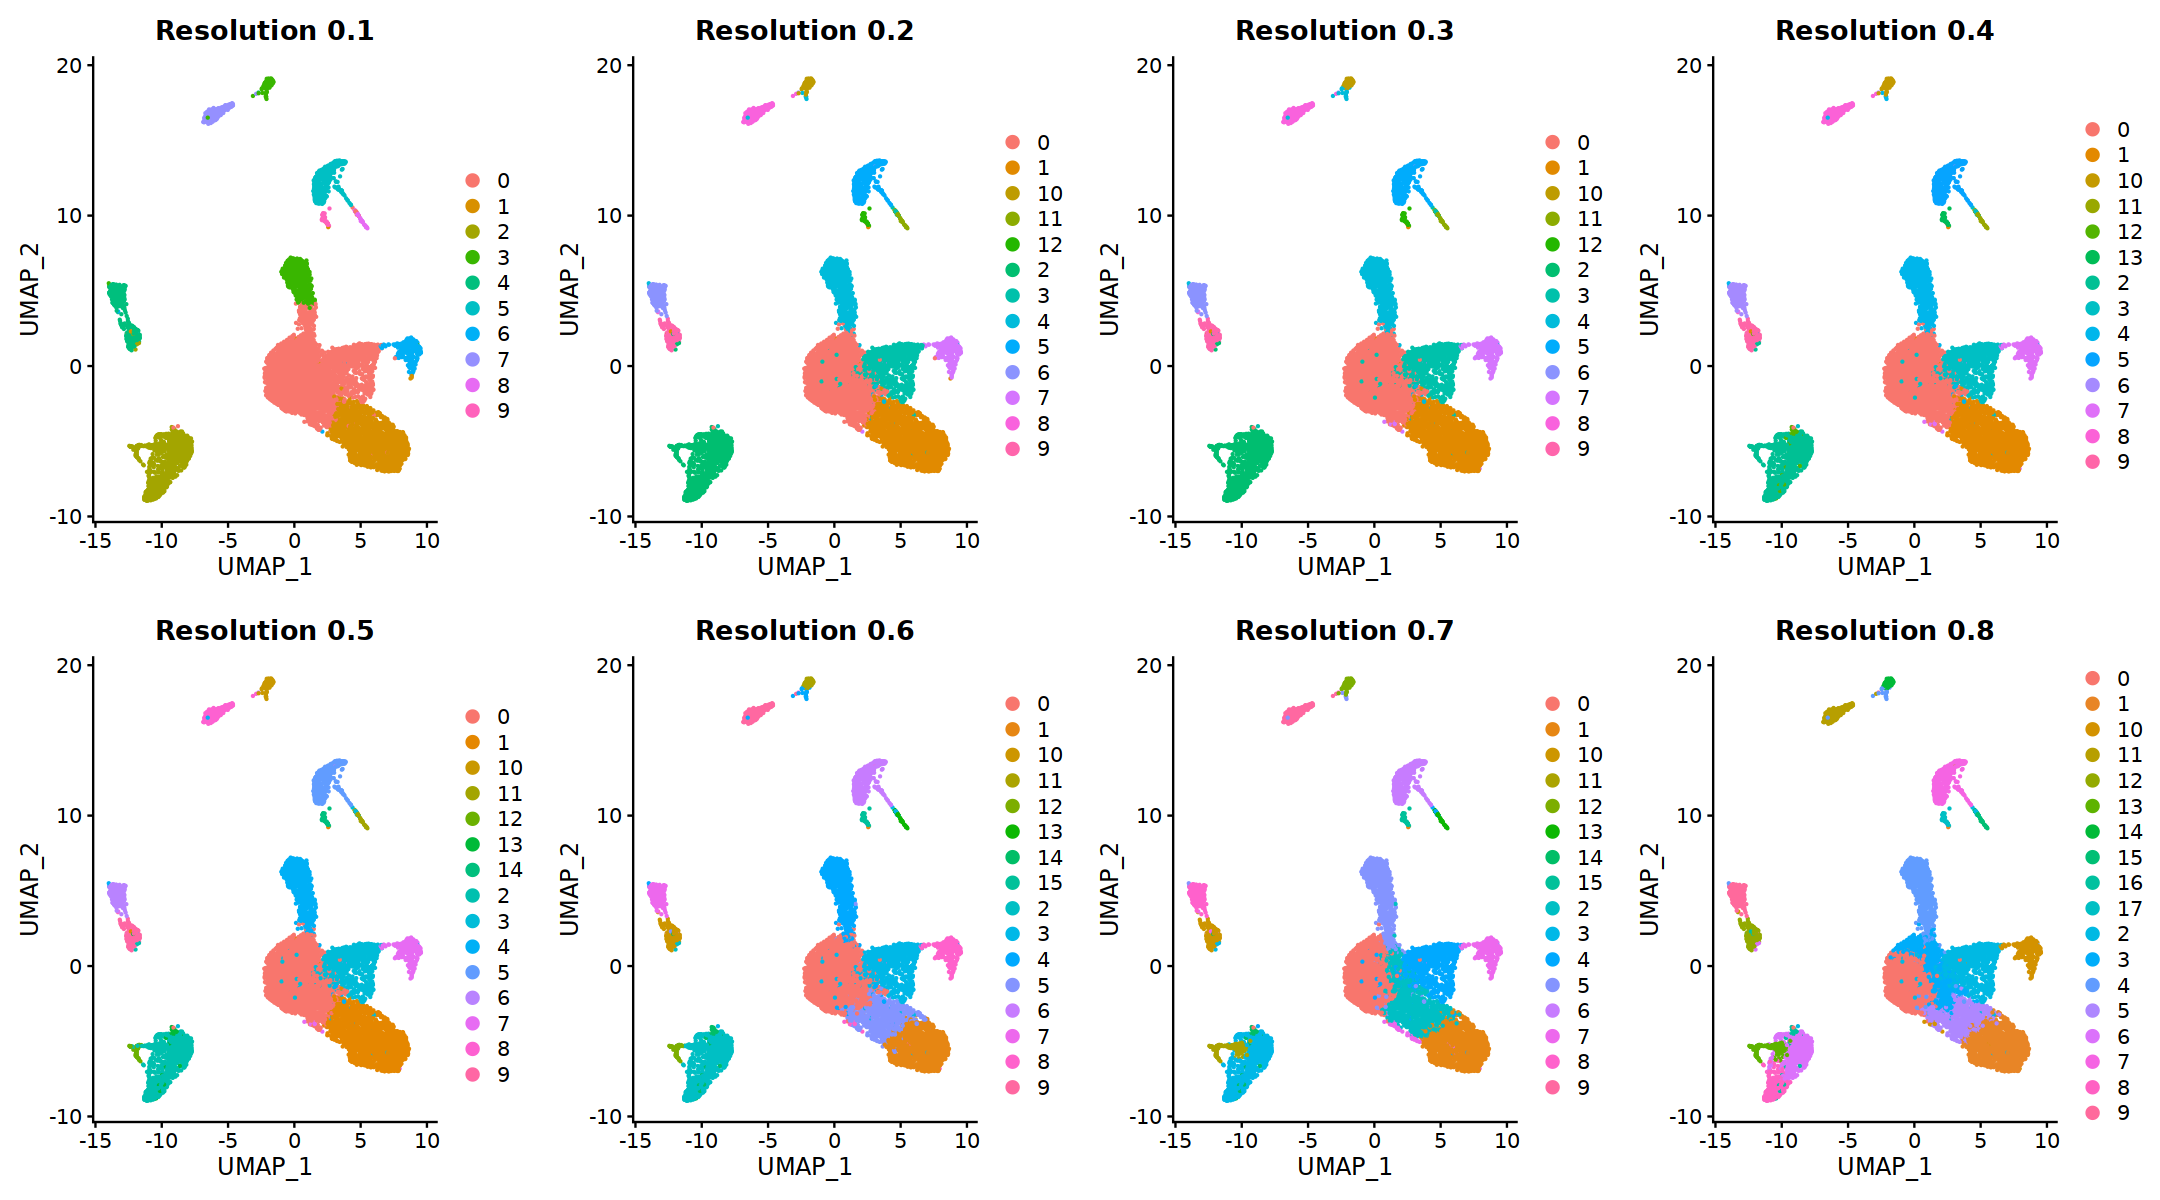

In [25]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [26]:
reso=0.3

In [27]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9799
Number of edges: 333668

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9305
Number of communities: 13
Elapsed time: 1 seconds


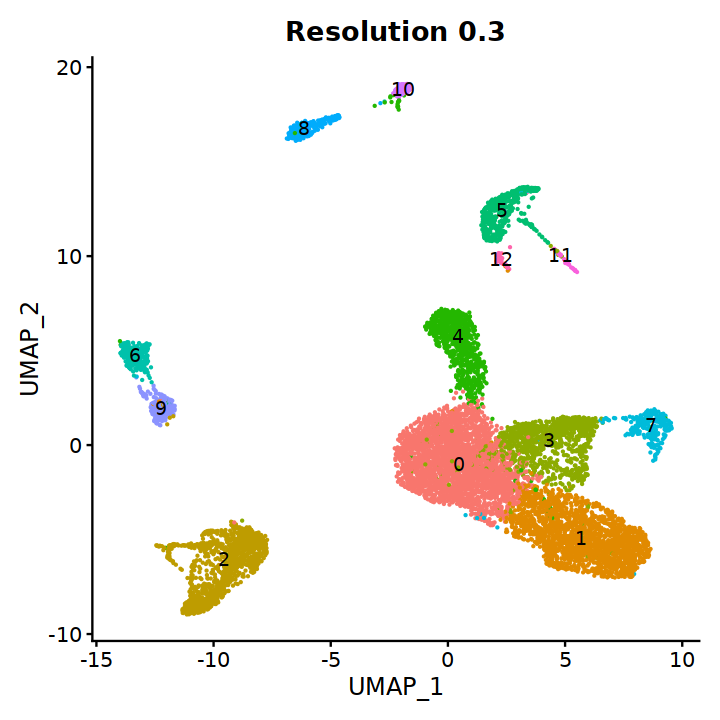

In [28]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Obtain markers to corroborate doublets by gene expression

In [29]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, logfc.threshold = 0.1, 
                              random.seed=0, max.cells.per.ident=1000,
                              only.pos=TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



In [30]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-first_clustering_{timepoint}.csv")))

In [31]:
markers <- c("PTPRC","nCount_RNA", "nFeature_RNA",
             "doublet_score",
             "CD3E", "CD3D","NCAM1","KLRD1","FCGR3A",
             "CD14", "CD68", 
             "S100A8", "SPP1", "CD163", "MSR1",
             "HBB")

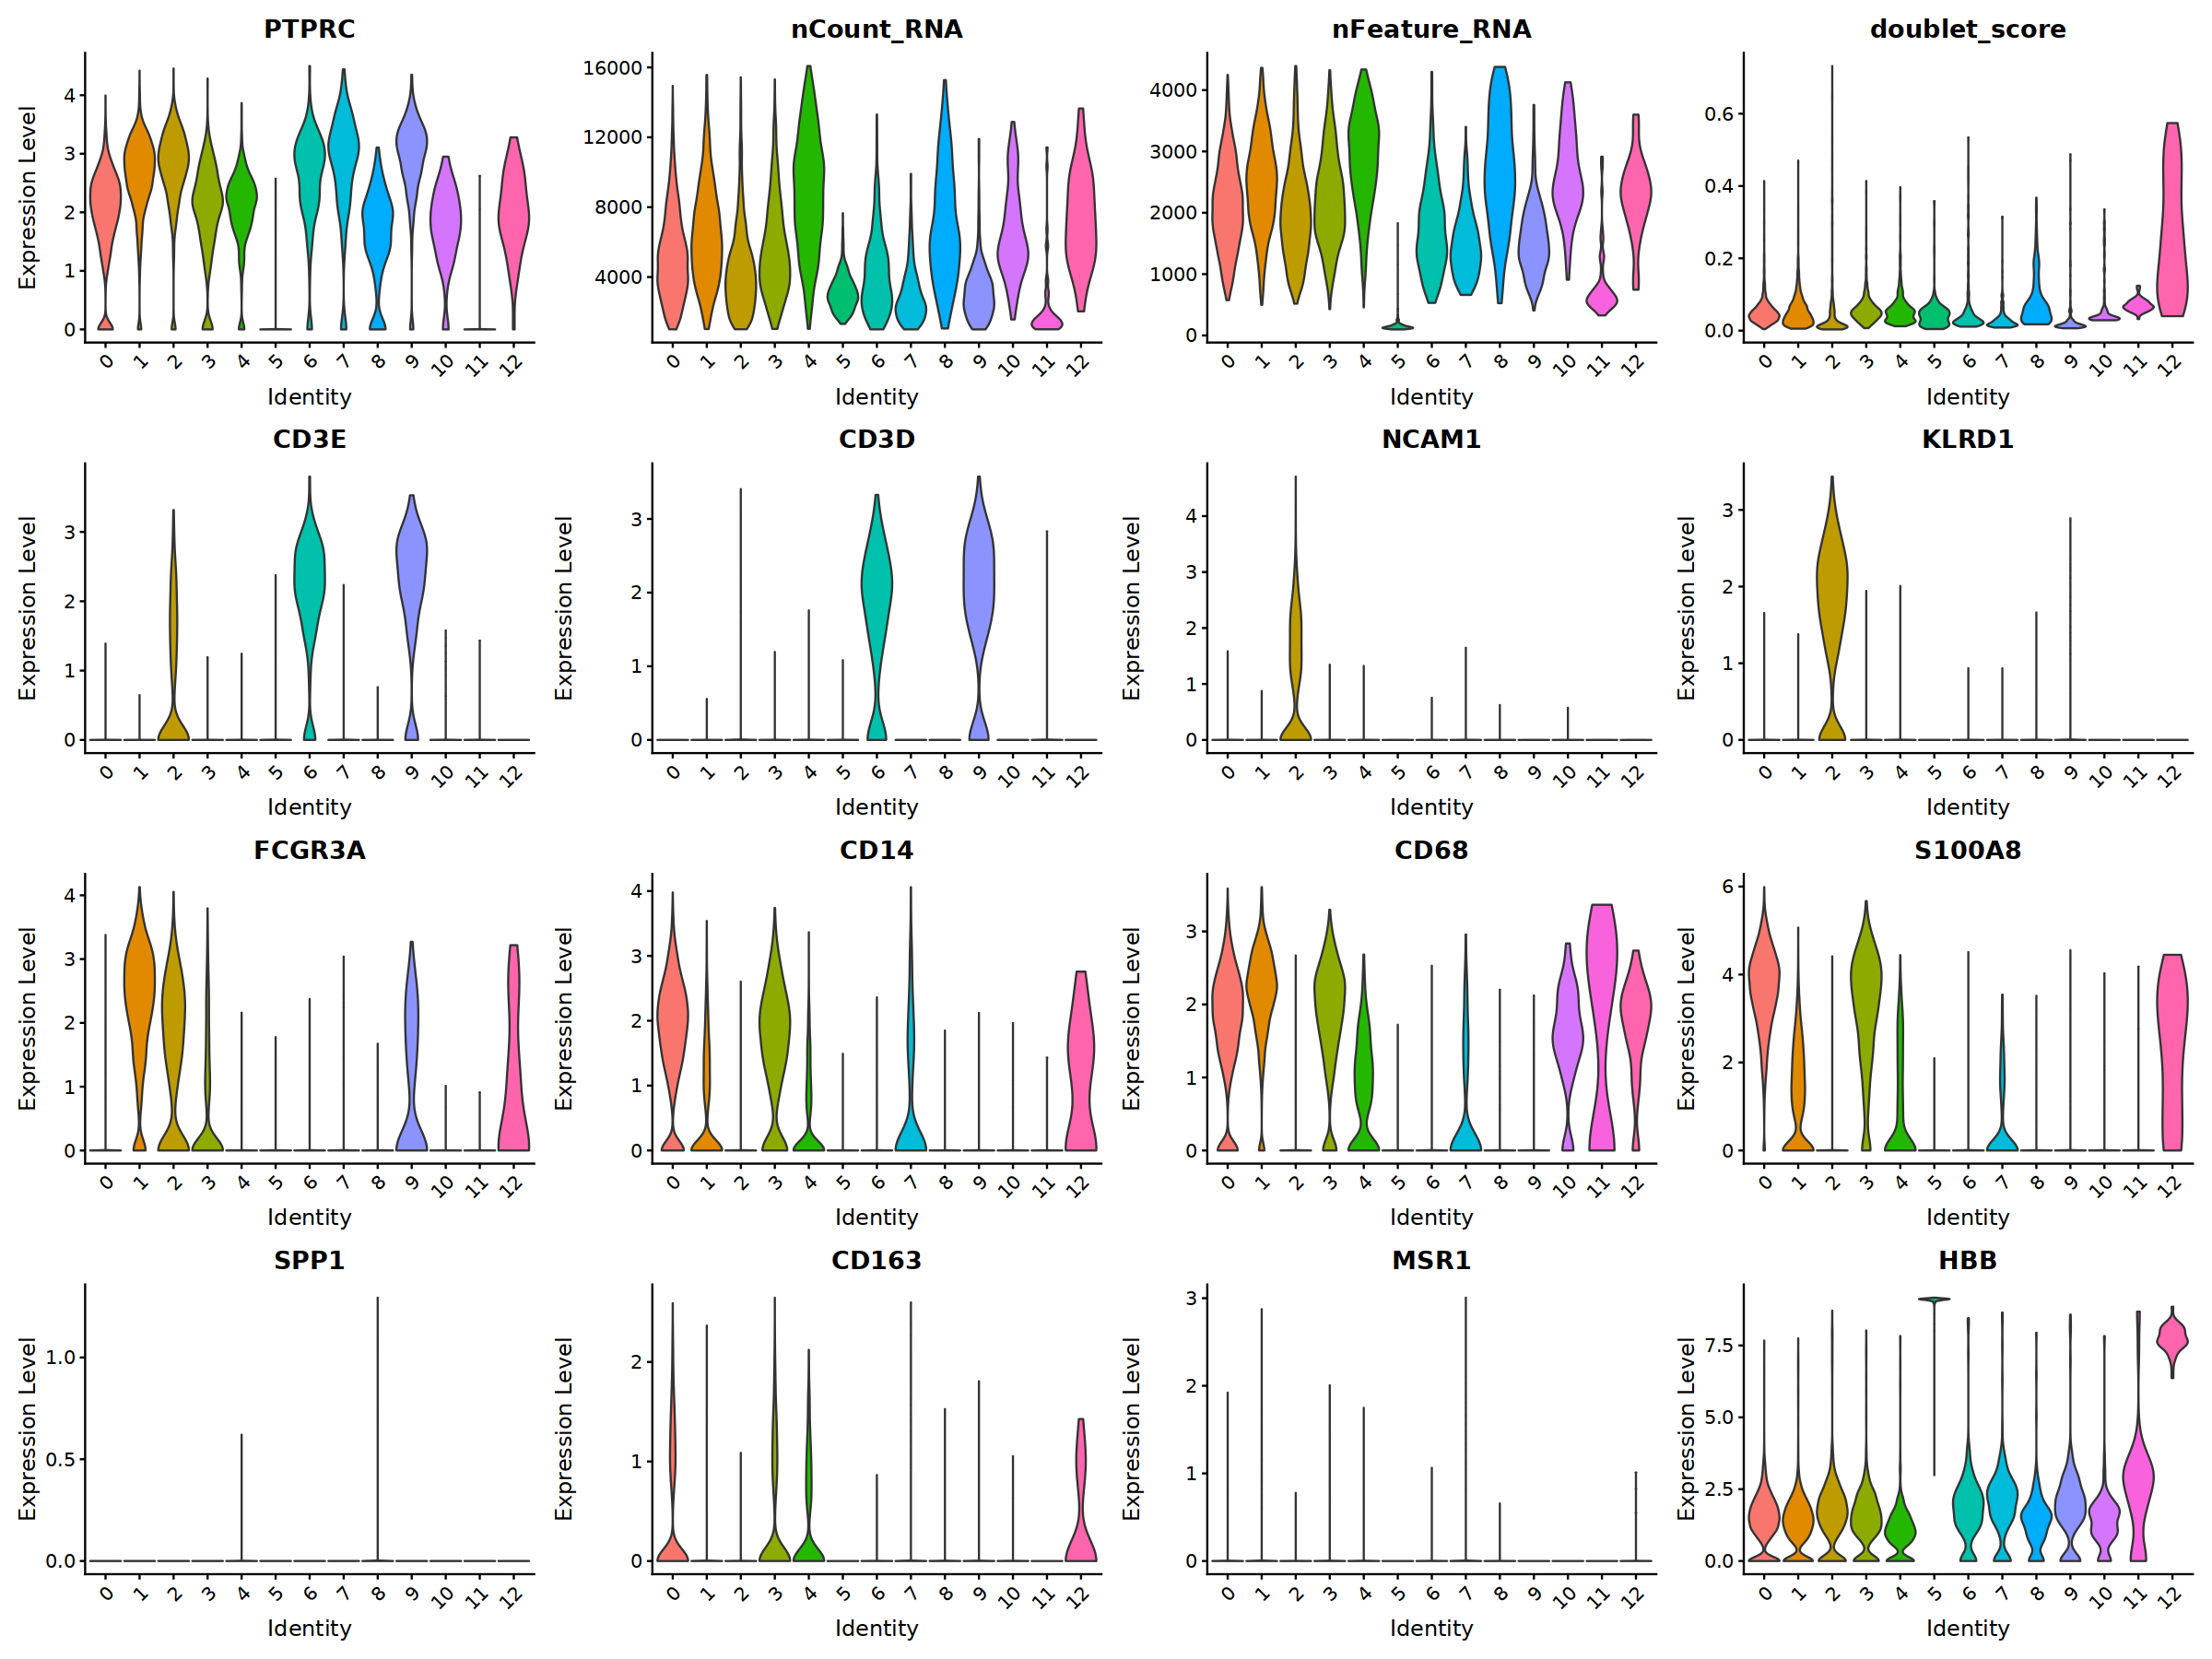

In [32]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers, ncol=4, pt.size = 0)

In [33]:
# options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
# FeaturePlot(seurat_obj, ncol=4,
#             feature=markers)

Clusters to filter out

In [34]:
c <- 5
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
HBB,1.018935e-205,8.156815,1.000,0.814,2.681226e-201,5,HBB
ALAS2,8.094738e-293,5.427686,0.996,0.023,2.130049e-288,5,ALAS2
HBA2,1.279729e-290,5.390637,0.998,0.036,3.367479e-286,5,HBA2
HBA1,5.397362e-286,4.981593,0.998,0.033,1.420262e-281,5,HBA1
HBD,8.284003e-221,4.822225,0.832,0.030,2.179853e-216,5,HBD
CA1,3.968707e-250,4.771326,0.890,0.015,1.044325e-245,5,CA1
UBB1,7.215388e-197,3.937785,0.998,0.745,1.898657e-192,5,UBB
AHSP,5.120300e-215,3.684126,0.804,0.013,1.347356e-210,5,AHSP
SNCA,1.158217e-189,3.301730,0.815,0.078,3.047733e-185,5,SNCA


In [35]:
c <- 12
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
HBB1,1.001465e-25,2.5246536,1.000,0.822,2.635256e-21,12,HBB
HBA21,1.237492e-75,2.3732242,1.000,0.076,3.256335e-71,12,HBA2
HBA11,6.576724e-76,2.2709390,1.000,0.073,1.730599e-71,12,HBA1
ALAS21,2.272083e-82,1.9284621,1.000,0.064,5.978759e-78,12,ALAS2
AHSP1,3.525314e-54,1.3444707,0.708,0.047,9.276512e-50,12,AHSP
SLC25A371,9.606919e-24,1.3243242,0.792,0.217,2.527965e-19,12,SLC25A37
UBB2,6.556320e-17,1.3169138,1.000,0.756,1.725230e-12,12,UBB
SNCA3,5.984242e-37,1.2462462,0.750,0.109,1.574693e-32,12,SNCA
SLC4A11,6.109760e-39,1.2075129,0.521,0.036,1.607722e-34,12,SLC4A1


In [36]:
c <- 11
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
PPBP1,5.479424e-57,6.919429,0.964,0.195,1.441856e-52,11,PPBP
PF41,6.450592e-69,6.008904,0.929,0.117,1.697409e-64,11,PF4
TUBB12,1.680046e-89,5.772034,0.982,0.100,4.420872e-85,11,TUBB1
GP91,3.701138e-94,5.650711,0.911,0.064,9.739175e-90,11,GP9
GNG112,4.007990e-70,5.247924,0.875,0.109,1.054663e-65,11,GNG11
CAVIN21,6.411160e-77,4.996365,0.946,0.099,1.687033e-72,11,CAVIN2
ITGA2B1,8.816272e-105,4.920607,0.946,0.062,2.319914e-100,11,ITGA2B
MPIG6B1,7.733076e-94,4.798590,0.875,0.057,2.034882e-89,11,MPIG6B
PTCRA2,1.256780e-103,4.739531,0.875,0.041,3.307091e-99,11,PTCRA


### Remove cells

In [37]:
seurat_obj <- subset(seurat_obj, idents=c(5,12), invert=TRUE)

In [38]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
26272    42 


An object of class Seurat 
26272 features across 9298 samples within 1 assay 
Active assay: RNA (26272 features, 0 variable features)
 4 dimensional reductions calculated: pca, pca_filt, harmony, umap

## Re-do embedding and clustering

In [39]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [40]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 26272 9298 
metadata(0):
assays(2): counts logcounts
rownames(26272): AL627309.1 AL627309.3 ... AC004556.3 AC007325.2
rowData names(0):
colnames(9298): T4_1_AAACCTGAGTACGCGA-1 T4_1_AAACCTGAGTGCTGCC-1 ...
  T4_2_TTTGTCATCCAGATCA-1 T4_2_TTTGTCATCTAAGCCA-1
colData names(18): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(4): PCA PCA_FILT HARMONY UMAP
mainExpName: RNA
altExpNames(0):

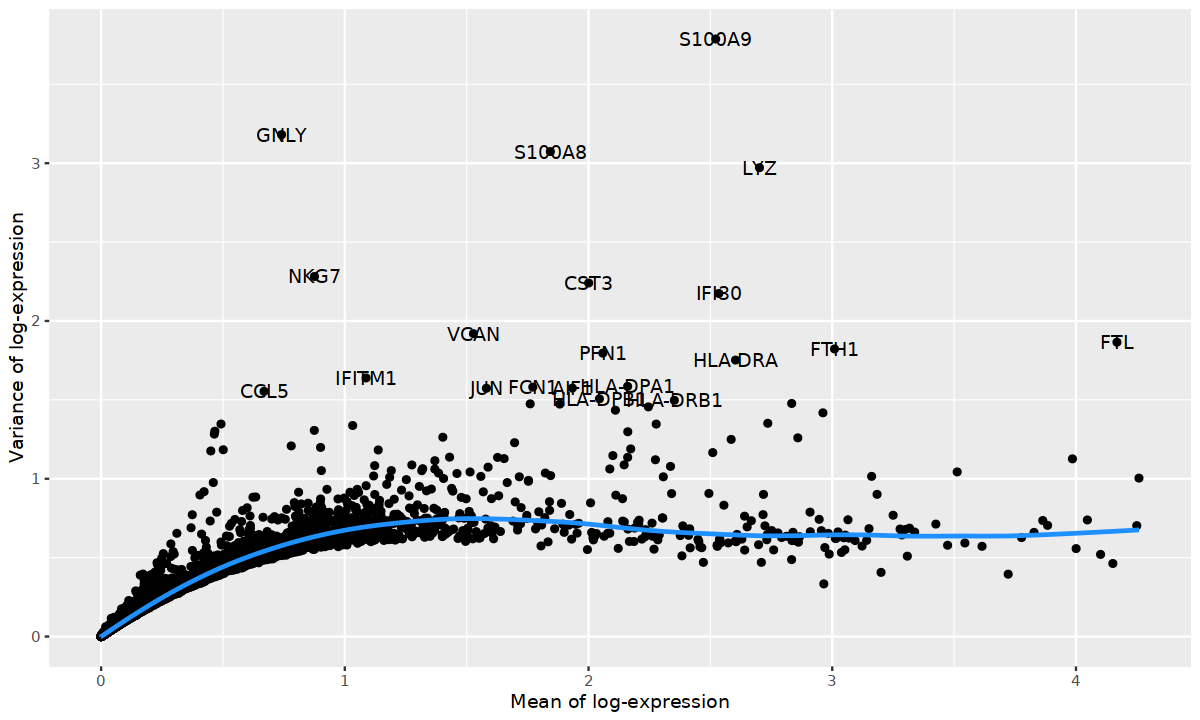

In [41]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [42]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 1556

In [43]:
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]
length(hvgs)

[1] 1451

In [44]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  IFI30, LYZ, AIF1, FCN1, PSAP, FTL, CTSS, LST1, HLA-DRA, CYBB 
	   S100A9, NAMPT, SPI1, SERPINA1, GRN, CD68, LYN, PLXDC2, S100A6, HLA-DRB1 
	   CST3, S100A11, HLA-DQB1, FOS, SAT1, MNDA, FTH1, MS4A6A, SLC8A1, VCAN 
Negative:  CD247, PRF1, SKAP1, CTSW, GZMA, CD7, CST7, GNLY, PRKCH, NKG7 
	   ZAP70, IL32, IL2RB, GZMB, SYNE2, KLRK1, CD96, SAMD3, IL2RG, GZMM 
	   KLRD1, SLC38A1, KLRB1, CD69, LCK, CCL5, HOPX, GZMH, PYHIN1, KLRC1 
PC_ 2 
Positive:  TYROBP, S100A4, S100A11, IFITM3, FCER1G, IFITM2, LGALS1, FCGR3A, CRIP1, NKG7 
	   S100A6, ZFP36, PRF1, IFI30, GZMA, IFITM1, GNLY, CTSS, CD52, KLRD1 
	   NEAT1, CST7, JUNB, GNG2, SERPINA1, IL2RB, FCN1, KLRK1, KLRC1, LST1 
Negative:  FAM30A, TFPI, CASC15, NKAIN2, EGFL7, BEX3, MSRB3, CD34, MEIS1, ERG 
	   MMRN1, PTCRA, GNG11, IGHM, SPINK2, SMIM24, ZNF521, NPR3, AJ009632.2, ANGPT1 
	   ITM2C, GP9, RHEX, ITGA2B, PROM1, CAVIN2, MPIG6B, MZB1, TUBB1, PRSS57 
PC_ 3 
Positive:  LILRA4, JCHAIN, MZB1, CLEC4C,

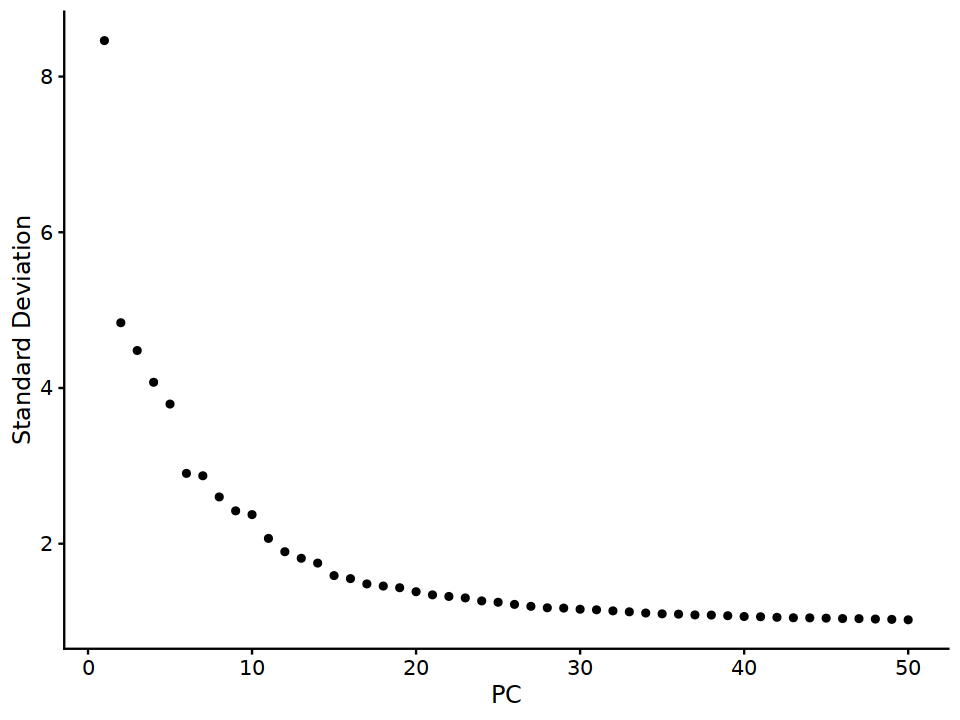

In [45]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [46]:
comp=20

In [47]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

10:53:12 UMAP embedding parameters a = 0.9922 b = 1.112

10:53:12 Read 9298 rows and found 20 numeric columns

10:53:12 Using Annoy for neighbor search, n_neighbors = 30

10:53:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:53:13 Writing NN index file to temp file /scratch_tmp/33943067/Rtmp2fDrGF/file191ec694a47af

10:53:13 Searching Annoy index using 1 thread, search_k = 3000

10:53:16 Annoy recall = 100%

10:53:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:53:18 Initializing from normalized Laplacian + noise (using irlba)

10:53:18 Commencing optimization for 500 epochs, with 386334 positive edges

10:53:43 Optimization finished



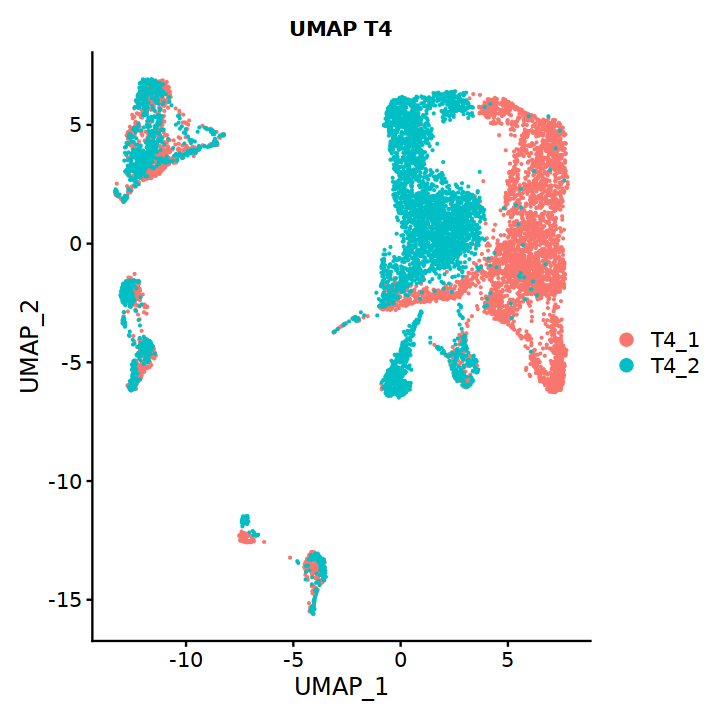

In [48]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

In [49]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony converged after 7 iterations



In [50]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

10:53:56 UMAP embedding parameters a = 0.9922 b = 1.112

10:53:56 Read 9298 rows and found 20 numeric columns

10:53:56 Using Annoy for neighbor search, n_neighbors = 30

10:53:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:53:57 Writing NN index file to temp file /scratch_tmp/33943067/Rtmp2fDrGF/file191ec8f5af80

10:53:57 Searching Annoy index using 1 thread, search_k = 3000

10:53:59 Annoy recall = 100%

10:54:00 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:54:01 Initializing from normalized Laplacian + noise (using irlba)

10:54:01 Commencing optimization for 500 epochs, with 392164 positive edges

10:54:27 Optimization finished



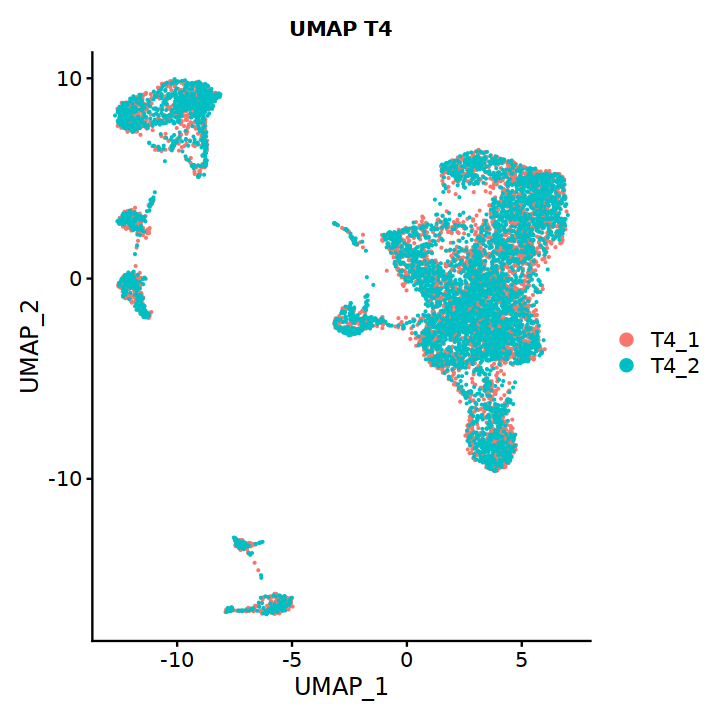

In [51]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

### Clustering 

In [52]:
seurat_obj <- FindNeighbors(seurat_obj, reduction = "harmony", dims = 1:comp)

Computing nearest neighbor graph

Computing SNN



In [53]:
reso = 0.2

In [54]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9298
Number of edges: 330177

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9402
Number of communities: 11
Elapsed time: 1 seconds


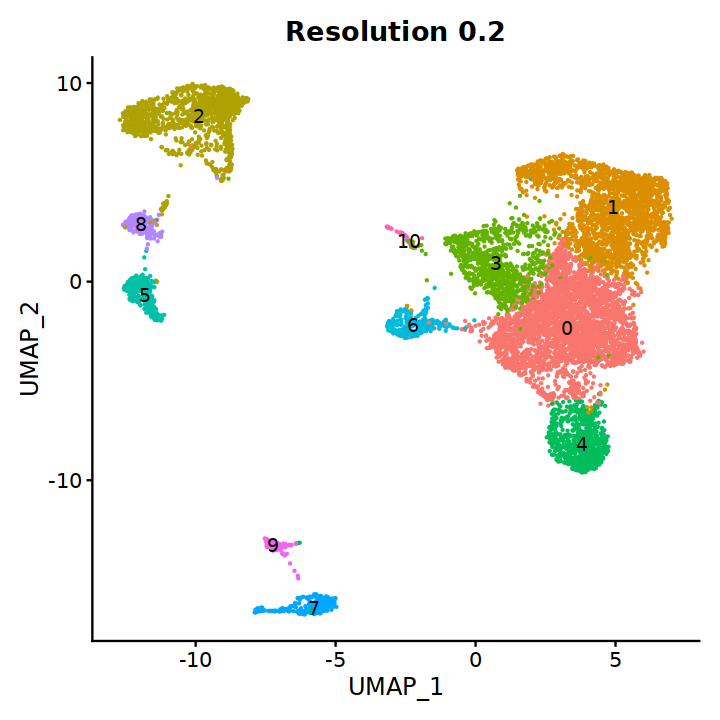

In [55]:
options(repr.plot.width = 6, repr.plot.height =6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Compute markers

In [56]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, 
                              logfc.threshold = 0.1, only.pos = T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



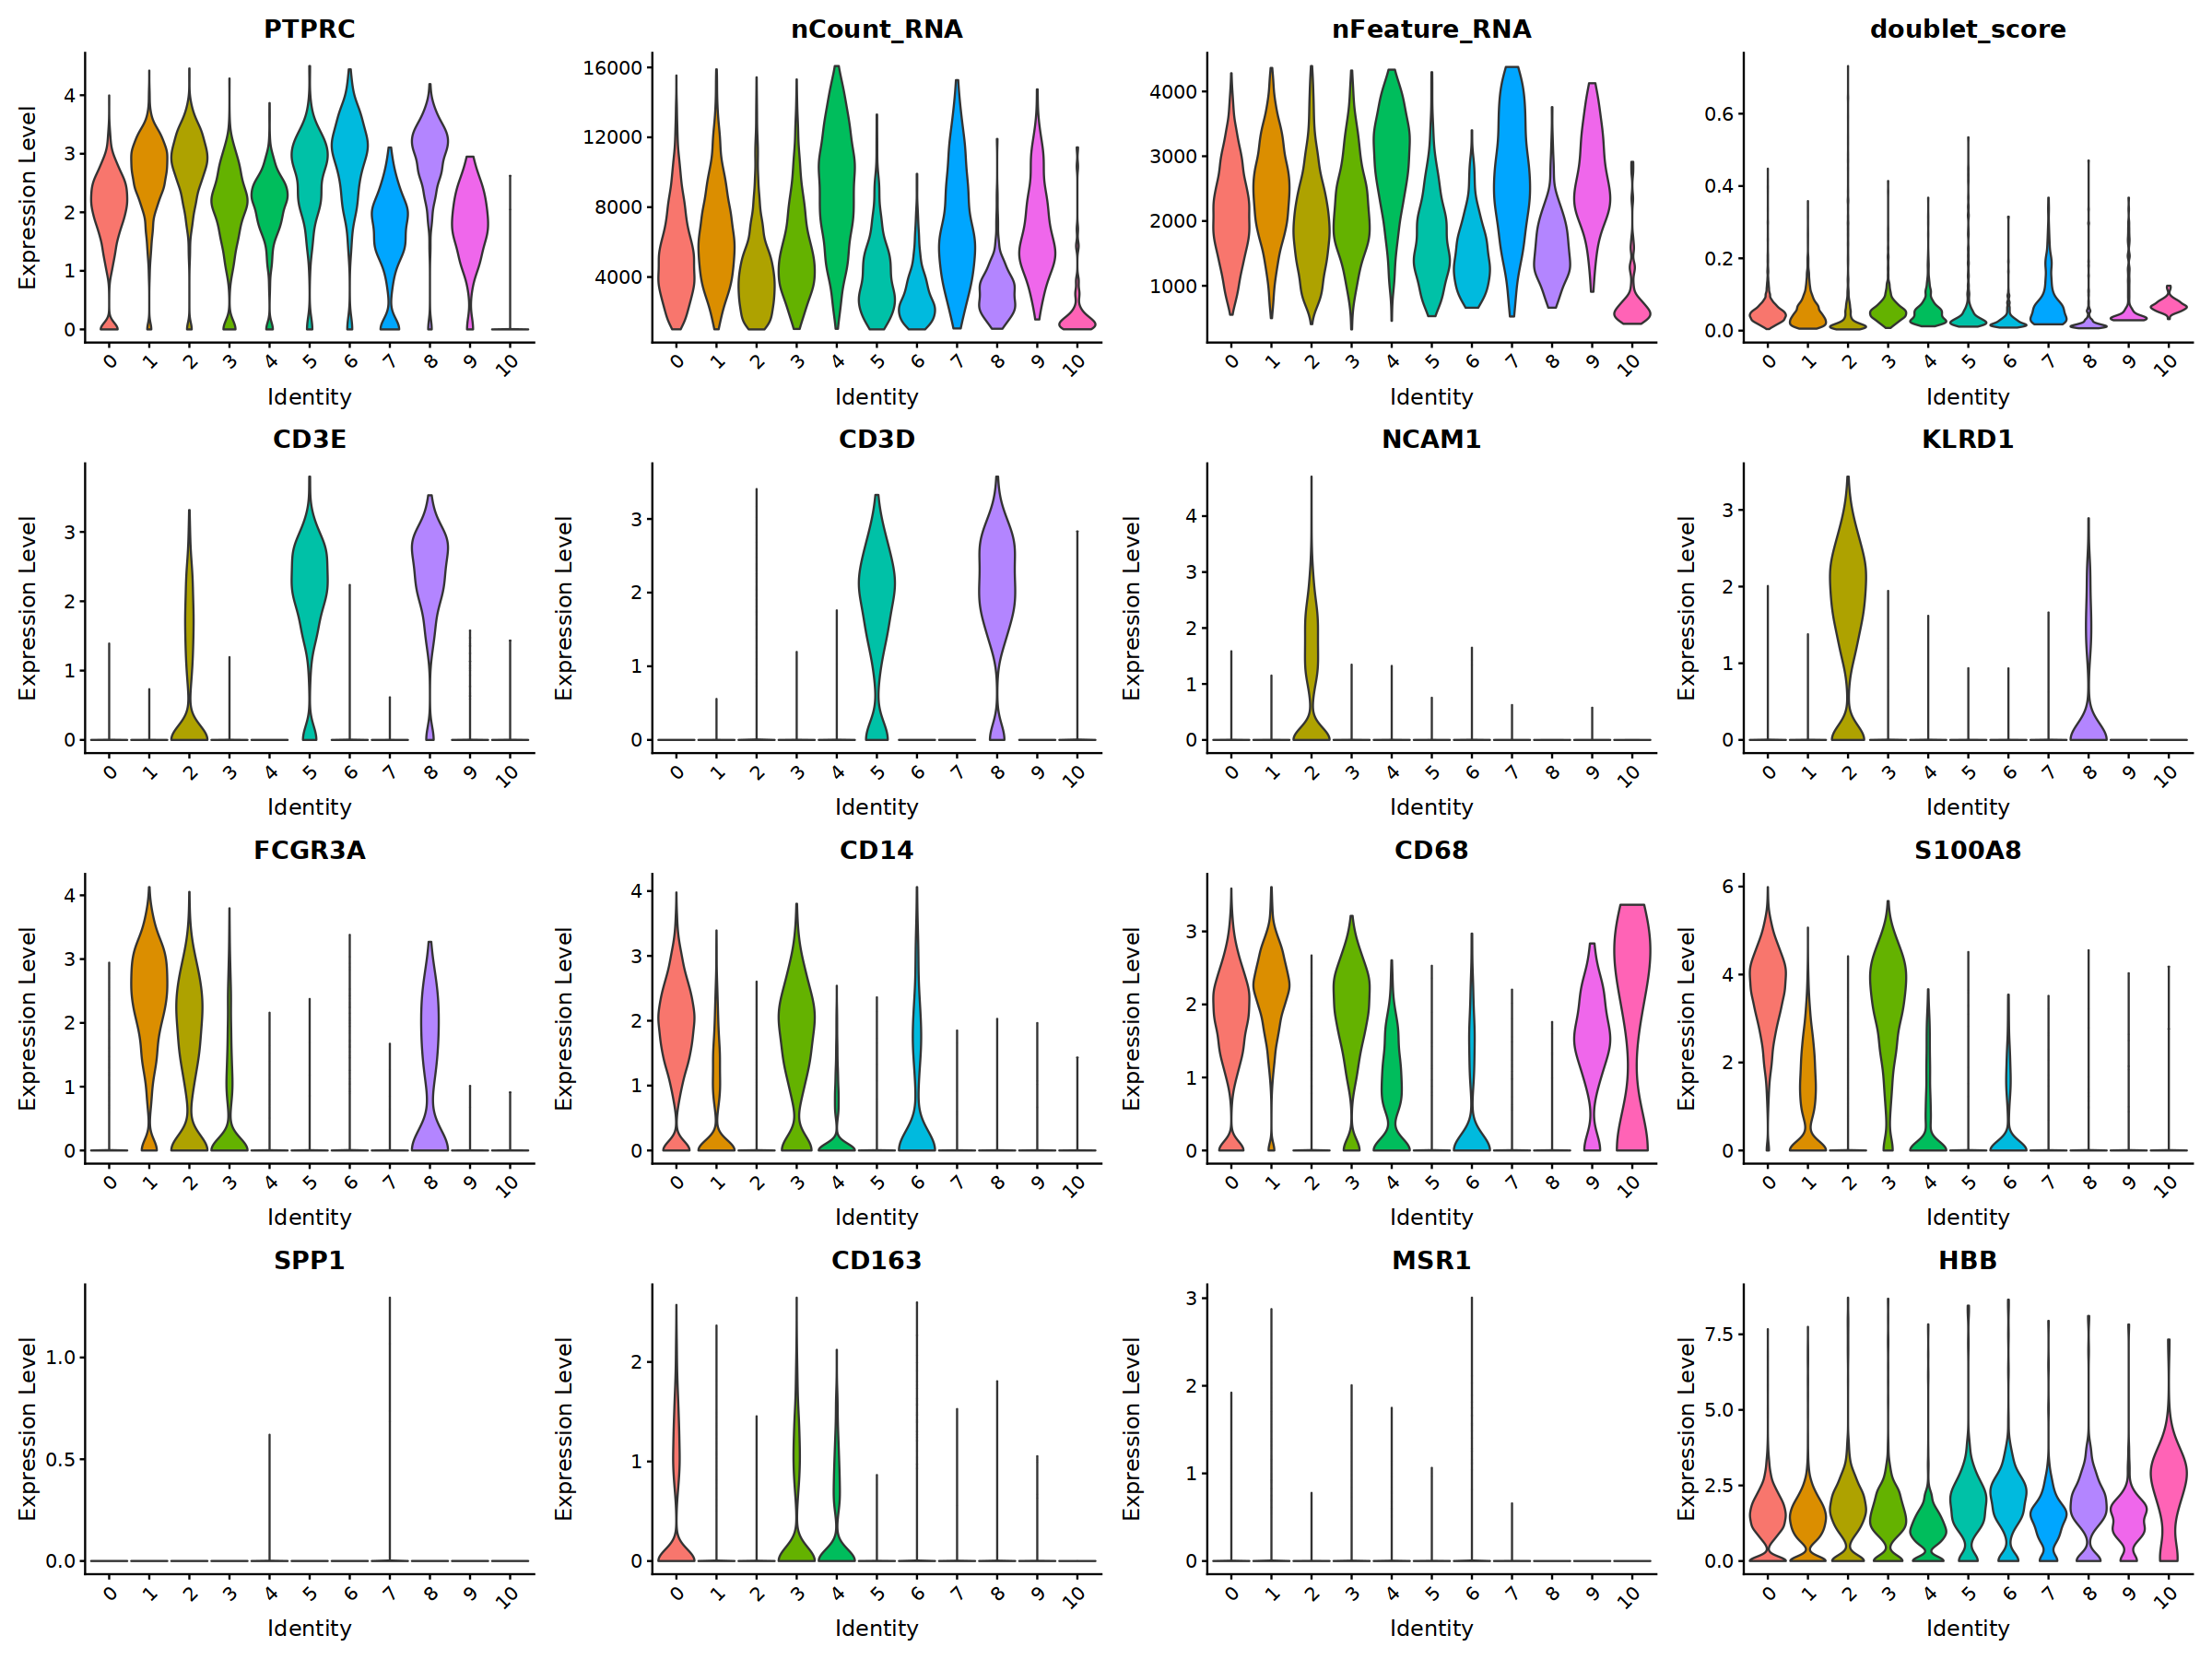

In [57]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers, ncol=4, pt.size = 0)

# Save

In [58]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.rds")))

In [59]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.csv")))

# Session Info

In [60]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_